In [3]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import RobustScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.impute import IterativeImputer


# Load dataset
df = pd.read_csv('f1_2019_to_2022_all_drivers_all_data.csv', low_memory=False)

# Convert time columns to seconds
time_columns = ['LapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time']
for col in time_columns:
    df[col] = pd.to_timedelta(df[col]).dt.total_seconds()

# Convert binary columns to integer type
df['Rainfall'] = df['Rainfall'].astype(int)
df['FreshTyre'] = df['FreshTyre'].astype(int)
df['IsAccurate'] = df['IsAccurate'].astype(int)


# Categorize weather condition based on centroid values of Kmeans clustering
def categorize_weather(row):
    if row['Rainfall'] > 0:
        return 'Rainy'
    elif row['AirTemp'] > 28.43213126:
        return 'high'
    elif row['AirTemp'] > 21.31279265:
        return 'medium'
    elif row['AirTemp'] > 12.84901403:
        return 'low'
    else:
        return 'very_low'

df['Weather_Category'] = df.apply(categorize_weather, axis=1)
df['Original_Weather_Category'] = df['Weather_Category']
df = pd.get_dummies(df, columns=['Weather_Category'])


# Keep the original Driver and Circuit for EDA
df['Original_Driver'] = df['Driver']
df['Original_Circuit'] = df['Circuit']

# Create Track temperature category based on the result of Kmeans clustering 
df['TrackTemp_Cat'] = pd.cut(df['TrackTemp'], bins=[0, 18.96764999, 27.87457484, 35.04425766, 41.75142602, 50.51006013], labels=['VERY_LOW', 'Low', 'Medium', 'Warm', 'High'])
df['Original_TrackTemp_Cat'] = df['TrackTemp_Cat']
df = pd.get_dummies(df, columns=['TrackTemp_Cat'])


#Feature Engineering with weather condition features
df['TrackConditionIndex'] = (df['AirTemp'] + df['TrackTemp'] + df['Humidity'] + df['Pressure'] +
                             df['WindSpeed'] + df['Rainfall']) / 6

# Tyre Age Interaction with TrackTemp 
df['TyreAge_TrackTemp'] = df['TyreLife'] * df['TrackTemp']

df['Temp_Rainfall_Interaction'] = df['TrackTemp'] * df['Rainfall']

# One-hot encoding
df = pd.get_dummies(df, columns=['Driver', 'Compound', 'Team','TrackStatus','Circuit'])

# Drop irrelevant columns
columns_to_drop = ['Time', 'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
                   'PitOutTime', 'PitInTime', 'LapStartDate', 'Deleted', 'DeletedReason', 'FastF1Generated',
                   'IsPersonalBest', 'Sector3Time','LapStartTime','Sector2Time','Sector1Time'] 
df.drop(columns=columns_to_drop, inplace=True)


# Select numerical values for scaling and imputation
numeric_features = ['Humidity', 'Pressure', 'WindDirection', 'WindSpeed','TrackTemp','AirTemp','TrackConditionIndex','TyreAge_TrackTemp','Rainfall','SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST']


# Use IterativeImputer for more sophisticated imputation method
iterative_imputer = IterativeImputer(random_state=42)
df[numeric_features] = iterative_imputer.fit_transform(df[numeric_features])


## Separate Rainy / dry days ##
# 1. Separate LapTime as dry or wet(rainy) condition ( since lapTime of rainy day would be recognized as outliers)
# 2. Remove Outliers for dry condition LapTime
# 3. Build Combined LapTime df (Outliers for dry days are deleted)

# Flag for rainy conditions
df['IsRainy'] = df['Rainfall'].apply(lambda x: 1 if x > 0 else 0)

# Separate dataframes for dry and wet conditions
df_dry = df[df['IsRainy'] == 0]
df_wet = df[df['IsRainy'] == 1]

# Remove Outliers for dry days using the IQR method that effective to removes extreme outliers
Q1_dry = df_dry['LapTime'].quantile(0.25)
Q3_dry = df_dry['LapTime'].quantile(0.75)
IQR_dry = Q3_dry - Q1_dry
lower_bound_dry = Q1_dry - 1.5 * IQR_dry
upper_bound_dry = Q3_dry + 1.5 * IQR_dry
df_dry_filtered = df_dry[(df_dry['LapTime'] >= lower_bound_dry) & (df_dry['LapTime'] <= upper_bound_dry)]
df_dry_filtered = df_dry_filtered.copy()
df_wet = df_wet.copy()


## Scaling to the selected numeric features ##
robust_scaler = RobustScaler()

# Applying scaling to the numeric features
df_dry_filtered[numeric_features] = robust_scaler.fit_transform(df_dry_filtered[numeric_features])
df_wet[numeric_features] = robust_scaler.transform(df_wet[numeric_features])  # Use transform, not fit_transform

# Combining the datasets after scaling
df_combined = pd.concat([df_dry_filtered, df_wet], ignore_index=True)
df_combined.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79375 entries, 0 to 79374
Data columns (total 143 columns):
 #    Column                               Dtype   
---   ------                               -----   
 0    DriverNumber                         int64   
 1    LapTime                              float64 
 2    LapNumber                            float64 
 3    Stint                                float64 
 4    SpeedI1                              float64 
 5    SpeedI2                              float64 
 6    SpeedFL                              float64 
 7    SpeedST                              float64 
 8    TyreLife                             float64 
 9    FreshTyre                            int64   
 10   Position                             float64 
 11   IsAccurate                           int64   
 12   AirTemp                              float64 
 13   Humidity                             float64 
 14   Pressure                             float64 
 15   

In [4]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor


# Drop Strings columns
df_combined = df_combined.drop(['Original_Driver', 'Original_Circuit', 'Original_Weather_Category', 'Original_TrackTemp_Cat'], axis=1)


# Impute missing LapTime values (considering other strategy that best suits data)
df_combined['LapTime'].fillna(method='ffill', inplace=True)

# KNN Imputation
#imputer = KNNImputer(n_neighbors=5)
#df['LapTime'] = imputer.fit_transform(df[['LapTime']])

# Define features and target
X = df_combined.drop('LapTime', axis=1)
y = df_combined['LapTime']

# Handle class imbalance
class_counts = df_combined['Rainfall'].value_counts()
scale_pos_weight = class_counts[0] / class_counts[1]

# stratify with Rainfall to handle imbalance 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df_combined['Rainfall'])

# Train the model with class weight adjustment
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, scale_pos_weight=scale_pos_weight, n_jobs=-1)
xgb_model.fit(X_train, y_train)

# Predictions and evaluation
predictions = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print(f"Baseline RMSE for Dry_filtered df: {rmse}")

########

# Initialize KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the model
xgb = XGBRegressor(random_state=42)

# Set up the hyperparameters to test in GridSearchCV
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}

# Custom scorer for RMSE
neg_rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

# Setup GridSearchCV with multiple scoring metrics
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=kf,
                           scoring={'RMSE': neg_rmse_scorer, 'MAE': 'neg_mean_absolute_error', 'R2': 'r2'},
                           refit='RMSE',n_jobs=-1)
grid_search.fit(X, y)  # Make sure to fit on scaled X to maintain consistency

# Get the best model and print results
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

best_rmse = -grid_search.cv_results_['mean_test_RMSE'][grid_search.best_index_]


best_mae = -grid_search.cv_results_['mean_test_MAE'][grid_search.best_index_]
best_r2 = grid_search.cv_results_['mean_test_R2'][grid_search.best_index_]

print("Best model parameters:", best_params)
print(f"Best CV RMSE: {best_rmse:.3f}")
print(f"Best CV MAE: {best_mae:.3f}")
print(f"Best CV R²: {best_r2:.3f}")

#from sklearn.experimental import enable_iterative_imputer
#from sklearn.impute import IterativeImputer
# Use IterativeImputer for more sophisticated imputation
#iterative_imputer = IterativeImputer(random_state=42)
#df_combined[numeric_features] = iterative_imputer.fit_transform(df_combined[numeric_features])



Baseline RMSE for Dry_filtered df: 2.348832547477973


/opt/anaconda3/envs/COMS30035_labs/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best model parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500}
Best CV RMSE: 1.716
Best CV MAE: 0.803
Best CV R²: 0.984


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
# Feature importances
feature_importances = xgb_model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]

for index in sorted_indices:
    print(f"{X_train.columns[index]}: {feature_importances[index]}")


Circuit_Azerbaijan Grand Prix: 0.14930440485477448
Circuit_Sakhir Grand Prix: 0.08132688701152802
Circuit_Chinese Grand Prix: 0.07544548064470291
Pressure: 0.07026011496782303
Circuit_Bahrain Grand Prix: 0.05703328177332878
Circuit_Hungarian Grand Prix: 0.05447196960449219
Circuit_United States Grand Prix: 0.052610114216804504
Circuit_Singapore Grand Prix: 0.046892642974853516
SpeedFL: 0.04532086104154587
Circuit_French Grand Prix: 0.037626802921295166
Circuit_Monaco Grand Prix: 0.034225329756736755
IsAccurate: 0.028294308111071587
Compound_INTERMEDIATE: 0.025360727682709694
Year: 0.020322779193520546
Weather_Category_low: 0.01848793961107731
Circuit_Saudi Arabian Grand Prix: 0.015401603654026985
Circuit_Canadian Grand Prix: 0.014844811521470547
Circuit_Belgian Grand Prix: 0.013160094618797302
Circuit_Dutch Grand Prix: 0.0105969849973917
Rainfall: 0.01046406663954258
TrackConditionIndex: 0.009006026200950146
Circuit_Japanese Grand Prix: 0.008195189759135246
SpeedI2: 0.00713821640238165

TrackConditionIndex: 25.88%
Circuit_Azerbaijan Grand Prix: 25.41%
Circuit_Belgian Grand Prix: 24.92%
Humidity: 23.54%
Circuit_Singapore Grand Prix: 22.06%
Circuit_United States Grand Prix: 21.29%
Compound_INTERMEDIATE: 21.17%
Circuit_Russian Grand Prix: 18.48%
WindDirection: 17.83%
Circuit_Bahrain Grand Prix: 16.68%
Pressure: 16.19%
TrackStatus_4.0: 15.82%
Circuit_French Grand Prix: 15.71%
Circuit_Abu Dhabi Grand Prix: 15.58%
TrackTemp_Cat_VERY_LOW: 14.37%
Circuit_Turkish Grand Prix: 14.18%
WindSpeed: 11.48%
Circuit_Japanese Grand Prix: 10.91%
Circuit_Chinese Grand Prix: 9.95%
TrackTemp_Cat_Medium: 8.63%
TrackStatus_24.0: 8.42%
Compound_WET: 8.30%
Circuit_Saudi Arabian Grand Prix: 8.26%
TrackStatus_67.0: 7.52%
Position: 7.26%
TrackStatus_6.0: 7.26%
Circuit_Miami Grand Prix: 5.76%
TrackTemp_Cat_Low: 5.68%
Circuit_British Grand Prix: 5.58%
TrackStatus_26.0: 5.50%
TrackStatus_2.0: 5.30%
Weather_Category_medium: 5.29%
Circuit_German Grand Prix: 4.82%
Year: 4.78%
Circuit_Eifel Grand Prix: 4

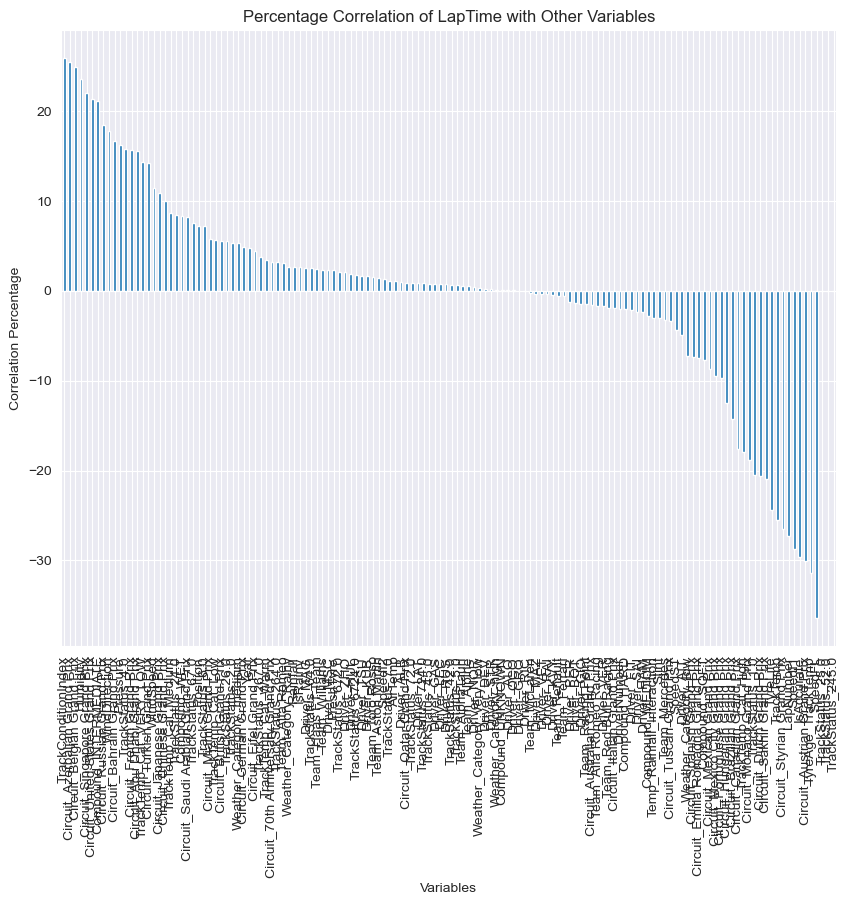

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate Spearman correlation matrix for df_combined
correlation_matrix = df_combined.corr(method='spearman')

# Focus on 'LapTime' correlations
laptime_correlations = correlation_matrix['LapTime'].drop('LapTime')  # drop self-correlation

# Convert correlations to percentage and sort in descending order
laptime_correlations_percentage = laptime_correlations * 100
laptime_correlations_sorted = laptime_correlations_percentage.sort_values(ascending=False)

# Convert to list and format the output
laptime_correlations_list = [(f"{index}: {value:.2f}%") for index, value in laptime_correlations_sorted.items()]

# Print the formatted list
for item in laptime_correlations_list:
    print(item)

# Optionally, visualize the correlations in descending order
plt.figure(figsize=(10, 8))
laptime_correlations_sorted.plot(kind='bar')
plt.title('Percentage Correlation of LapTime with Other Variables')
plt.ylabel('Correlation Percentage')
plt.xlabel('Variables')
plt.grid(True)
plt.show()


TrackConditionIndex: 25.88%
Humidity: 23.54%
WindDirection: 17.83%
Pressure: 16.19%
WindSpeed: 11.48%
Rainfall: 2.60%
SpeedI2: 1.34%
AirTemp: 1.10%
SpeedST: -4.42%
TrackTemp: -25.53%
SpeedI1: -28.69%
TyreAge_TrackTemp: -31.42%
SpeedFL: -36.43%


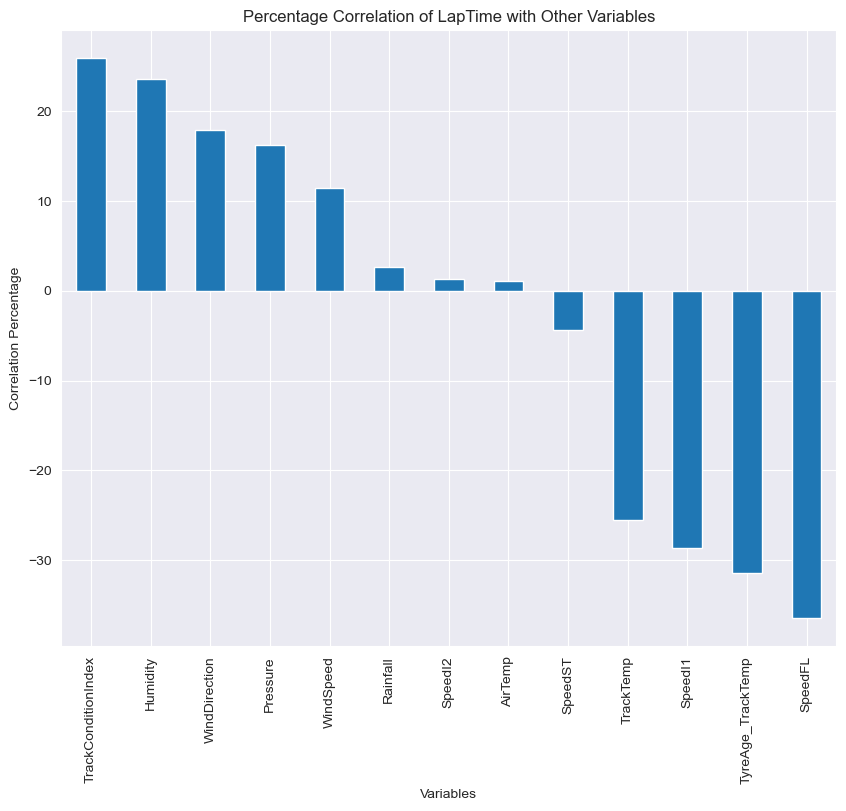

In [5]:
import pandas as pd
import matplotlib.pyplot as plt


correlation_matrix= df_combined[numeric_features + ['LapTime']].corr(method='spearman')

# Focus on 'LapTime' correlations
laptime_correlations = correlation_matrix['LapTime'].drop('LapTime')  # drop self-correlation

# Convert correlations to percentage and sort in descending order
laptime_correlations_percentage = laptime_correlations * 100
laptime_correlations_sorted = laptime_correlations_percentage.sort_values(ascending=False)

# Convert to list and format the output
laptime_correlations_list = [(f"{index}: {value:.2f}%") for index, value in laptime_correlations_sorted.items()]

# Print the formatted list
for item in laptime_correlations_list:
    print(item)

# Optionally, visualize the correlations in descending order
plt.figure(figsize=(10, 8))
laptime_correlations_sorted.plot(kind='bar')
plt.title('Percentage Correlation of LapTime with Other Variables')
plt.ylabel('Correlation Percentage')
plt.xlabel('Variables')
plt.grid(True)
plt.show()
